# Verify by Cross-Checking with AM

PWV -> nscale: -1.00
zenith -> airmass: 1.00


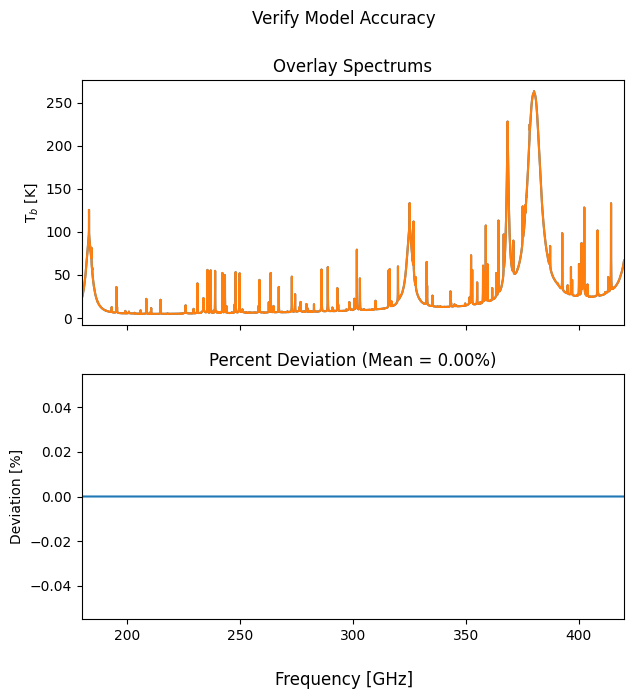

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
my_ozone = Ozone(am_model_data_path=data_path)

nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = my_ozone.data['freq']['map']

idx = 0     # idx in map to compare

model_spectrum, pwv_jacobian = my_ozone(pwv_map[idx], zenith_map[idx])
Tb_data = my_ozone.data['Tb_scalar_field'][idx][idx].reshape(model_spectrum.shape)
difference_spectrum = ((model_spectrum - Tb_data) / Tb_data) * 100

plot_scheme.verify_spectrum(model_spectrum, Tb_data, difference_spectrum, freq_channels)

In [ ]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

verify_map = np.zeros((my_ozone.data['Nscale']['points'], my_ozone.data['airmass']['points']))

for idx, nscale in enumerate(nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        Tb_data = my_ozone.data['Tb_scalar_field'][idx,jdx]
        model_spectrum = my_ozone(pwv_map[idx], zenith_map[jdx])[0][0] 
        comparison = ((model_spectrum - Tb_data) / Tb_data) * 100
        verify_map[idx,jdx] = np.mean(comparison)

Text(0.02, 0.5, 'Deviation [%]')

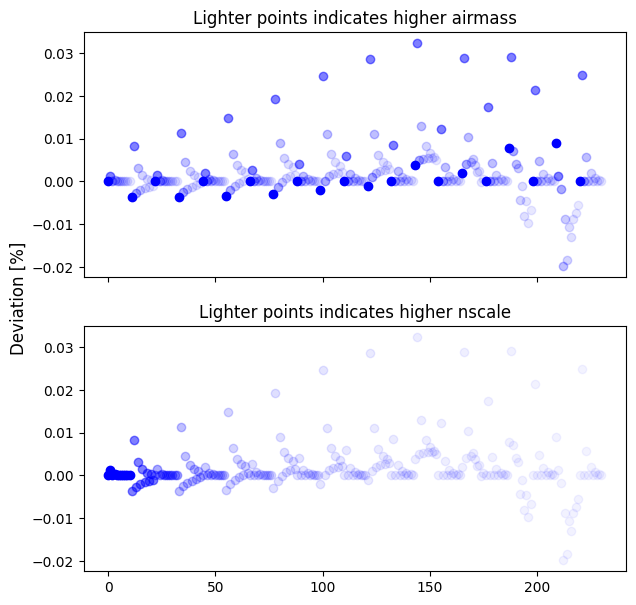

In [4]:
import matplotlib.colors as mcolors

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))

count = 0
for idx, nscale in enumerate(nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        color = mcolors.to_rgba('blue', alpha=1/(jdx+1))
        ax1.scatter(count, verify_map[idx,jdx], color=color)
        count += 1
ax1.set_title("Lighter points indicates higher airmass")

count = 0
for idx, nscale in enumerate(nscale_map):
    color = mcolors.to_rgba('blue', alpha=1/(idx+1))
    for jdx, airmass in enumerate(airmass_map):
        ax2.scatter(count, verify_map[idx,jdx], color=color)
        count += 1
ax2.set_title("Lighter points indicates higher nscale")

fig.supylabel("Deviation [%]")

# Verify using Jacobian

In [ ]:
# 2mm - 3mm (100 points)
# At each interval point - calc baseline spectrum; grab jacobian; multiply 1/100 to get difference if pwv increase by 1/100
# Add it to the spectrum 2mm PWV
# Repeat until we get to 3mm; cross-check with what the interpolation function spits out for 3mm

In [76]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
my_ozone = Ozone(am_model_data_path=data_path)

def jacobian_verify_w_pwv(zenith, start_pwv, end_pwv, freq_channels, points=100, plot=False):
    pwv_map = np.linspace(start_pwv, end_pwv, points)

    base_spectrum, base_jacobian = my_ozone(start_pwv, zenith)
    expected_spectrum, expected_jacobian = my_ozone(end_pwv, zenith)

    test_spectrum = base_spectrum
    for pwv in pwv_map:
        spectrum, jacobian = my_ozone(pwv, zenith)
        little_jacobian = jacobian / points
        test_spectrum += little_jacobian

    difference_spectrum = ((test_spectrum - expected_spectrum) / expected_spectrum) * 100

    if plot:
        import src.plot as plot_scheme
        plot_scheme.verify_spectrum(test_spectrum, expected_spectrum, difference_spectrum, freq_channels)
                
    return np.mean(difference_spectrum)

def jacobian_verify_w_zenith(pwv, start_zenith, end_zenith, freq_channels, points=100, plot=False):
    zenith_map = np.linspace(start_zenith, end_zenith, points)

    base_spectrum, base_jacobian = my_ozone(pwv, start_zenith)
    expected_spectrum, expected_jacobian = my_ozone(pwv, end_zenith)

    test_spectrum = base_spectrum
    for zenith in zenith_map:
        spectrum, jacobian = my_ozone(pwv, zenith)
        little_jacobian = jacobian * ((end_zenith-start_zenith)/points)
        test_spectrum += little_jacobian

    difference_spectrum = ((test_spectrum - expected_spectrum) / expected_spectrum) * 100

    if plot:
        import src.plot as plot_scheme
        plot_scheme.verify_spectrum(test_spectrum, expected_spectrum, difference_spectrum, freq_channels)
                
    return np.mean(difference_spectrum)

In [47]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)

last_pwv=pwv_map[-1]-1
last_zenith=zenith_map[-1]
first_pwv=pwv_map[0]
first_zenith=zenith_map[0]

size = 8
test_pwv_map = np.linspace(first_pwv, last_pwv, size)
test_zenith_map = np.linspace(first_zenith, last_zenith, size)
freq_channels = my_ozone.data['freq']['map']

print(f"Estimated Run Time: {(17*size**2)/60:.1f} min")

mean_deviations = np.zeros(shape=(test_pwv_map.size, test_zenith_map.size))
for idx, pwv in enumerate(test_pwv_map):
    for jdx, zenith in enumerate(test_zenith_map):
        start_pwv = pwv
        end_pwv = start_pwv + 1
        mean_deviations[idx,jdx] = jacobian_verify_w_pwv(zenith, start_pwv, end_pwv, freq_channels)

Estimated Run Time: 18.1 min
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -0.24
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -0.98
zenith -> airmass: 1.00
PWV -> nscale: -0.96
zenith -> airmass: 1.00
PWV -> nscale: -0.94
zenith -> airmass: 1.00
PWV -> nscale: -0.92
zenith -> airmass: 1.00
PWV -> nscale: -0.91
zenith -> airmass: 1.00
PWV -> nscale: -0.89
zenith -> airmass: 1.00
PWV -> nscale: -0.88
zenith -> airmass: 1.00
PWV -> nscale: -0.86
zenith -> airmass: 1.00
PWV -> nscale: -0.85
zenith -> airmass: 1.00
PWV -> nscale: -0.83
zenith -> airmass: 1.00
PWV -> nscale: -0.82
zenith -> airmass: 1.00
PWV -> nscale: -0.80
zenith -> airmass: 1.00
PWV -> nscale: -0.79
zenith -> airmass: 1.00
PWV -> nscale: -0.78
zenith -> airmass: 1.00
PWV -> nscale: -0.77
zenith -> airmass: 1.00
PWV -> nscale: -0.75
zenith -> airmass: 1.00
PWV -> nscale: -0.74
zenith -> airmass: 1.00
PWV -> nscale: -0.73
zenith -> airmass: 1.00
PWV -> nscale: -0.72
zenit

(-1.0, 1.0)

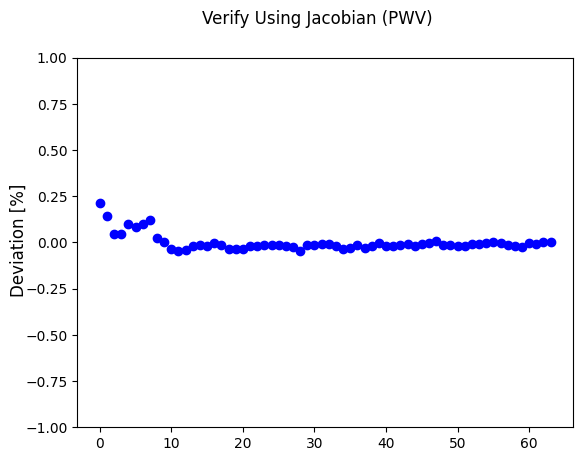

In [61]:
fig, ax = plt.subplots()
x_text = []
count=0
for idx, pwv in enumerate(test_pwv_map):
    for jdx, zenith in enumerate(test_zenith_map):
        x_text.append(f'({pwv:.1f}, {zenith:.1f})')
        ax.scatter(count, mean_deviations[idx,jdx], color='blue')
        count+=1

fig.supylabel("Deviation [%]")
fig.suptitle("Verify Using Jacobian (PWV)")

#ax.set_xticks(np.linspace(0, size**2-1, size**2))
#ax.set_xticklabels(x_text)
#plt.xticks(rotation=45, ha='right') 
plt.ylim(-1,1)

PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -0.24
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -0.98
zenith -> airmass: 1.00
PWV -> nscale: -0.96
zenith -> airmass: 1.00
PWV -> nscale: -0.94
zenith -> airmass: 1.00
PWV -> nscale: -0.92
zenith -> airmass: 1.00
PWV -> nscale: -0.91
zenith -> airmass: 1.00
PWV -> nscale: -0.89
zenith -> airmass: 1.00
PWV -> nscale: -0.88
zenith -> airmass: 1.00
PWV -> nscale: -0.86
zenith -> airmass: 1.00
PWV -> nscale: -0.85
zenith -> airmass: 1.00
PWV -> nscale: -0.83
zenith -> airmass: 1.00
PWV -> nscale: -0.82
zenith -> airmass: 1.00
PWV -> nscale: -0.80
zenith -> airmass: 1.00
PWV -> nscale: -0.79
zenith -> airmass: 1.00
PWV -> nscale: -0.78
zenith -> airmass: 1.00
PWV -> nscale: -0.77
zenith -> airmass: 1.00
PWV -> nscale: -0.75
zenith -> airmass: 1.00
PWV -> nscale: -0.74
zenith -> airmass: 1.00
PWV -> nscale: -0.73
zenith -> airmass: 1.00
PWV -> nscale: -0.72
zenith -> airmass: 1.00
PWV -> nsc

0.2110804146146867

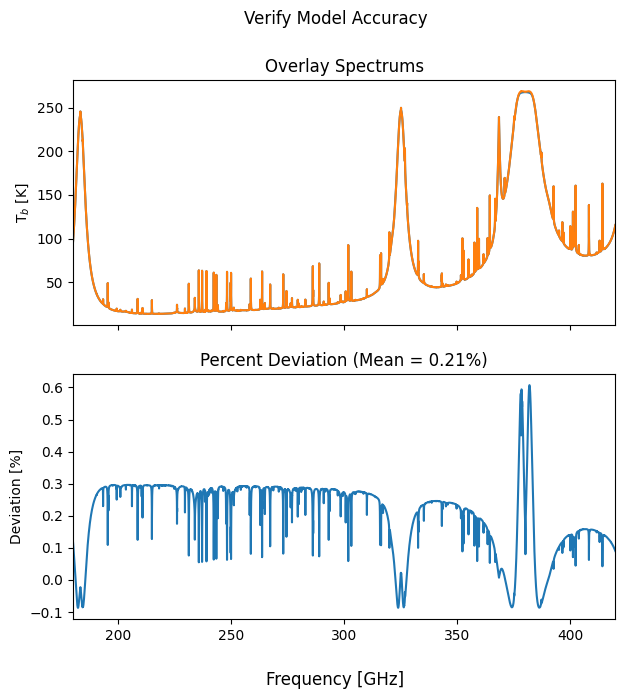

In [68]:
last_pwv=pwv_map[-1]-1
last_zenith=zenith_map[-1]
first_pwv=pwv_map[0]
first_zenith=zenith_map[0]

freq_channels = my_ozone.data['freq']['map']

jacobian_verify_w_pwv(0.045, 0.213, 1.213, freq_channels, plot=True)

PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.02
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nsc

30.567482702731414

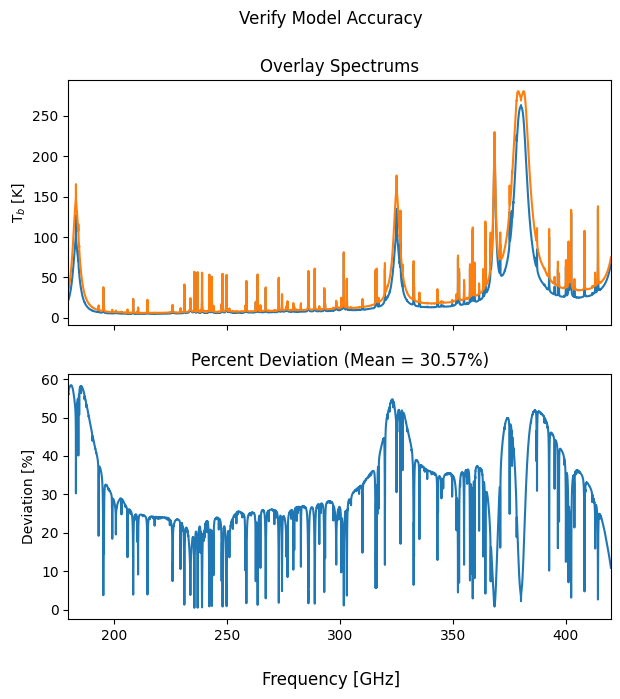

In [77]:
freq_channels = my_ozone.data['freq']['map']

jacobian_verify_w_zenith(0.213, 0.045, 0.045+0.15, freq_channels, plot=True)

In [78]:
0.15/100

0.0015